In [1]:
import numpy as np
import scipy.sparse as sparse
from time import time

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import FastALS
#import RiemannianOptimization
import ALS
#import SoftInput

from tqdm import tqdm

In [2]:
def generate_random_problem(rows, cols, fill_coef, true_rank, random_state):
    
    """
    Generate random matrix completion problem
    
    Args:
        rows (int) number of rows
        cols (int) number of collomns
        fill_coef (float) [0, 1]: coefficient of observed values
        true_rank (int): True rank of matrix
        random_state (int): random state for repetition of the results
    
    
    Returns:
        X (np.array): Completed matrix of the problem
        Xw (csr_matrix): Matrix with missed values
    """
    
    np.random.seed(random_state)

    diag = np.random.uniform(0, 1, true_rank)
    diag = np.sort(diag)[::-1]
        
    S = np.diag(diag)
    U = np.random.uniform(0, 1, (rows, true_rank))
    V = np.random.uniform(0, 1, (cols, true_rank))
        
    Qu, Ru = np.linalg.qr(U)
    Qv, Rv = np.linalg.qr(V)
    
    X = Qu.dot(S).dot(Qv.T)
    
    num = int(X.size * fill_coef)

    np.random.seed(random_state)
    row_ind = np.random.randint(0, rows, size=num)
    col_ind = np.random.randint(0, cols, size=num)

    Xw = sparse.csr_matrix((X[(row_ind, col_ind)], (row_ind, col_ind)), shape=X.shape, dtype=np.float)
    
    return X, Xw

# First experiment. Comparison of ALS and FastALS for different problems.

In [3]:
first = {'m': 300, 'n': 200, 'true_rank': 50, 'fill_coef': 0.3, 'approx_rank': 25, 'reg_coef': 0.3}
second = {'m': 800, 'n': 600, 'true_rank': 100, 'fill_coef': 0.1, 'approx_rank': 50, 'reg_coef': 0.3}
third = {'m': 1200, 'n': 900, 'true_rank': 100, 'fill_coef': 0.2, 'approx_rank': 50, 'reg_coef': 0.3}
forth = {'m': 2000, 'n': 1000, 'true_rank': 200, 'fill_coef': 0.2, 'approx_rank': 50, 'reg_coef': 0.3}
problems = [first, second, third, forth]

100%|██████████| 4/4 [03:19<00:00, 49.81s/it]


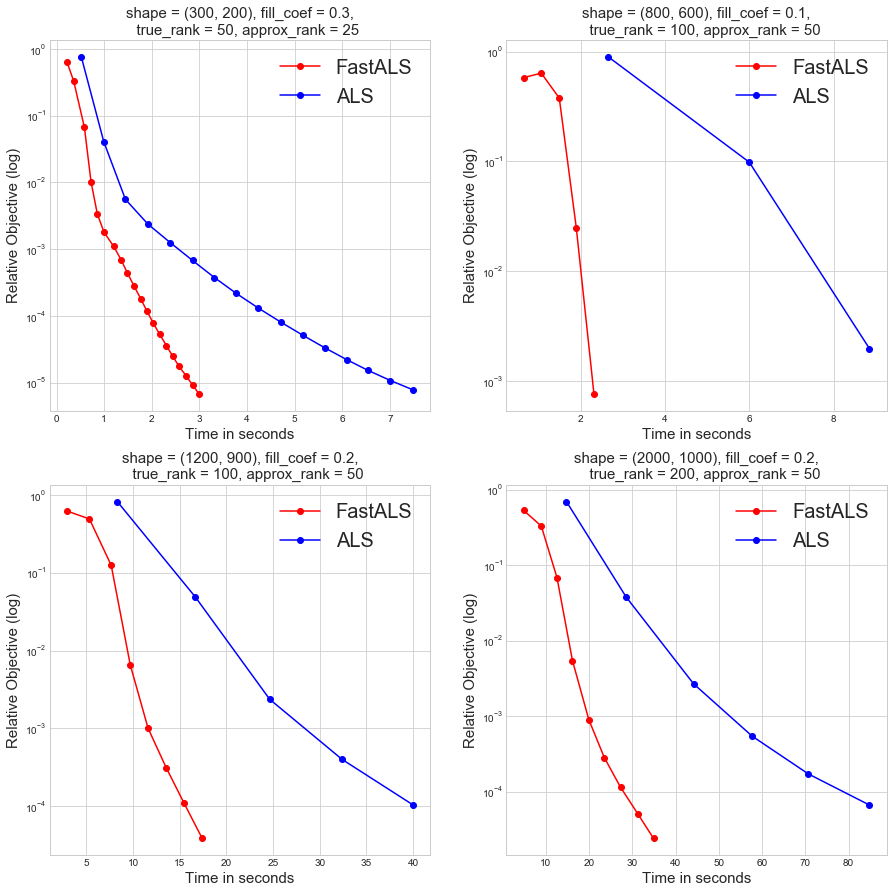

--- 200.53559398651123 seconds ---


In [4]:
fig = plt.figure(figsize=(15, 15))

max_iter = 50
tol = 1e-5

start_time = time()

for it in tqdm(range(0, 4)):
    m = problems[it]['m']
    n = problems[it]['n']
    reg_coef = problems[it]['reg_coef']
    true_rank = problems[it]['true_rank']
    fill_coef = problems[it]['fill_coef']
    approx_rank = problems[it]['approx_rank']
    
    X, Xw = generate_random_problem(rows=m, cols=n, fill_coef=fill_coef, true_rank = true_rank, random_state=1)
    
    
    fast_als = FastALS.FastALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    fast_als.fit(Xw, trace=True, debug_mode=False)
    
    als = ALS.ALS(rank=approx_rank, max_iter=max_iter, tol=tol, reg_coef=reg_coef)
    als.fit(Xw, trace=True, debug_mode = False)
    

    plot = fig.add_subplot(2, 2, it+1, yscale = 'log')
    
    plot.set_xlabel('Time in seconds', size = 15)
    plot.set_ylabel('Relative Objective (log)', size = 15)
    
    plot.plot(fast_als.get_time(), np.abs(fast_als.get_rel_obj()), '-o', c='r', label = 'FastALS')
    plot.plot(als.get_time(), np.abs(als.get_rel_obj()), '-o', c='b', label = 'ALS')
    
    plot.set_title("""shape = ({0}, {1}), fill_coef = {2},
    true_rank = {3}, approx_rank = {4}""".format(m, n, fill_coef, true_rank, approx_rank))
    plot.title.set_fontsize(15)
    plot.legend(loc = 'upper right', prop={'size': 20})
    
    
plt.show()
print("--- %s seconds ---" % (time() - start_time))

# There should be a conclusion of the first experiment